# **Project: Enhanced Credit Card Fraud Detection with Model Comparison and Interactive Data Visualization**

## Description/Objectives
The purpose of this project is to detect fraudulent credit card transactions using machine learning techniques and evaluate models based on imbalanced data.

## Research Question:
How do different sampling techniques (e.g., undersampling, oversampling with SMOTE) impact the precision, recall, and overall performance of fraud detection models in highly imbalanced credit card transaction datasets, and what trade-offs exist in implementing these techniques for real-world applications?

## Dataset Overview
- **Columns:** 31 (28 PCA-transformed features + Time, Amount, and Class)
- **Target Variable:** `Class` (0 = Non-Fraud, 1 = Fraud)
- **Challenge:** Highly imbalanced dataset (only 0.17% fraud transactions)

## Key Features and Challenges

### Key Features
1. **Handling Class Imbalance:**
   - Used SMOTE (oversampling) and random undersampling to address the extreme class imbalance and improve fraud detection.

2. **Sampling Technique Comparison:**
   - Compared baseline modeling, undersampling, and SMOTE oversampling using precision, recall, F1 score, AUC-ROC, and confusion matrices.

3. **SQL Integration:**
   - Utilized SQL for storing, querying, and analyzing model predictions to assess performance effectively.

4. **Performance Visualization:**
   - Highlighted trade-offs in recall and precision for each sampling method using confusion matrices and performance metrics.


# Exploratory Data Analysis (EDA)

## EDA Steps
- Load the dataset and inspect its structure.
- Visualize the distributions of features like `Amount` and `Time`.
- Analyze class distribution to understand the extent of imbalance.
- Check Missing/NA Values

In [1]:
# General Libraries
import os
import numpy as np
import pandas as pd
import warnings
import kagglehub

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score


# Libraries for Imbalanced Data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Utility Libraries
import sqlite3
from collections import Counter
from scipy.stats import norm

# Ignore Warnings
import warnings # Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the path to save the dataset
save_path = './Data/creditcard.csv'

# Check if the file exists
if not os.path.exists(save_path):
    print("File not found. Downloading the dataset...")
    
    # Download the dataset
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    print("Path to dataset files:", path)
    
    # Construct the file path
    file_path = os.path.join(path, 'creditcard.csv')
    
    # Verify the file exists in the downloaded path
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset not found in the expected location: {file_path}")
    
    # Create the Data folder if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Move the dataset to the Data folder
    df = pd.read_csv(file_path)
    df.to_csv(save_path, index=False)
    print(f"Dataset saved to: {save_path}")
else:
    print("Dataset already exists. Skipping download.")

# Load the dataset into a DataFrame
df = pd.read_csv(save_path)
print("Dataset loaded successfully!")

Dataset already exists. Skipping download.
Dataset loaded successfully!


In [3]:
# Dataset Shape
print("Dataset Shape:", df.shape)

# First 5 Rows
print("\nFirst 5 Rows:")
print(df.head())

Dataset Shape: (284807, 31)

First 5 Rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.

In [4]:
# Check for missing values and duplicates
print(f"Missing Values: {df.isnull().sum().max()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")

Missing Values: 0
Duplicate Rows: 1081


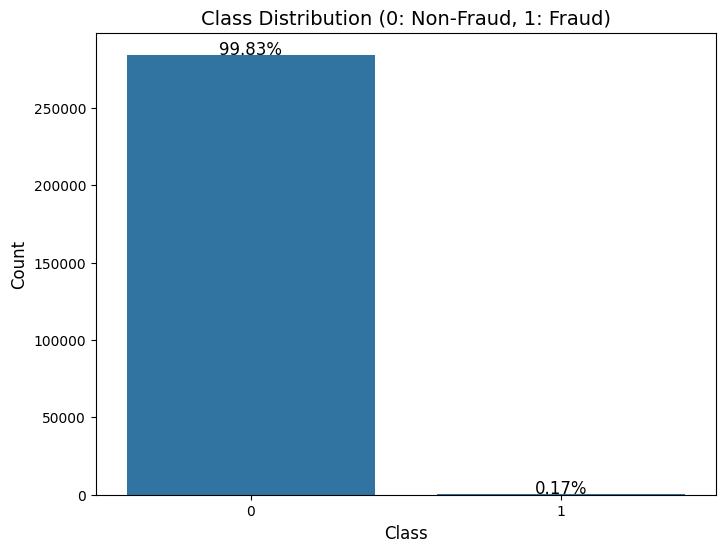

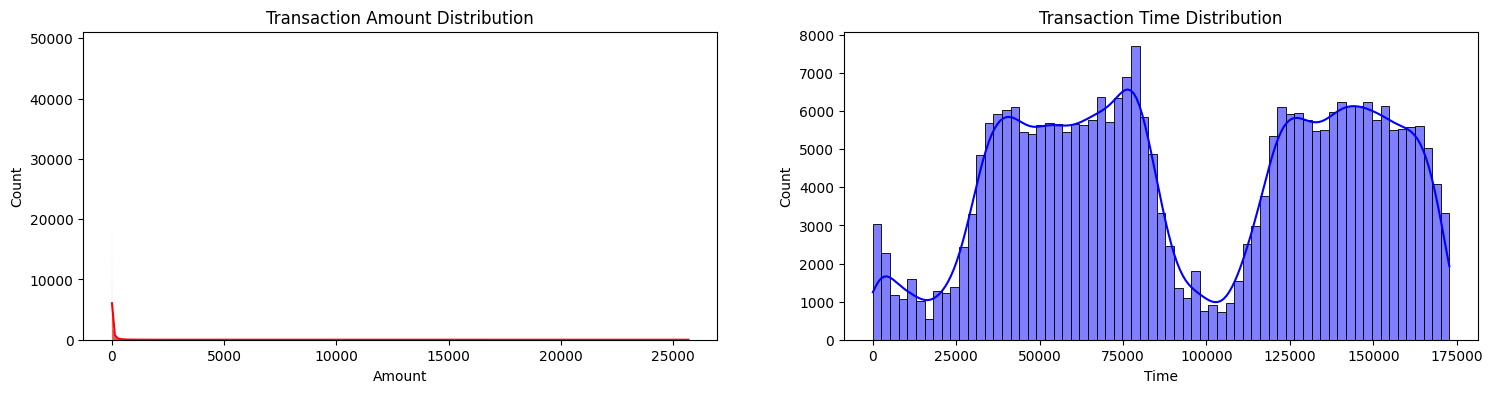

In [5]:
# Class distribution
class_counts = df['Class'].value_counts()
class_percentages = (class_counts / len(df)) * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate with percentages
for i, value in enumerate(class_counts):
    plt.text(i, value + 200, f"{class_percentages[i]:.2f}%", ha='center', fontsize=12)

plt.show()

# Feature distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
sns.histplot(df['Amount'], ax=axes[0], kde=True, color='r')
axes[0].set_title('Transaction Amount Distribution')
sns.histplot(df['Time'], ax=axes[1], kde=True, color='b')
axes[1].set_title('Transaction Time Distribution')
plt.show()


### **EDA Summary**

- **No Missing or Duplicate Values**:
  - The dataset contains no missing values or duplicate rows, ensuring data integrity.

- **Class Imbalance**:
  - The dataset is highly imbalanced, with **99.83% legitimate transactions (Class 0)** and only **0.17% fraudulent transactions (Class 1)**.
  - This imbalance can cause models to overfit by favoring the majority class, leading to poor fraud detection performance.

- **Feature Scaling**:
  - Features `Time` and `Amount` are **not PCA-transformed**, unlike other features in the dataset.
  - These features require scaling to ensure consistency with the PCA-transformed features.

- **Data Splitting**:
  - Before addressing the imbalance, the dataset should be split into **training** and **testing** sets to evaluate models on unseen data.
  - Sampling techniques (e.g., undersampling or SMOTE) will only be applied to the training set.

- **Random Under-Sampling**:
  - Balances the dataset by reducing legitimate transactions to match the number of fraudulent transactions (492 cases each).
  - While this approach addresses class imbalance, it risks losing important information by removing a large portion of legitimate transactions.

- **Key Observations**:
  - `scaled_amount` and `scaled_time` will be created to normalize `Amount` and `Time` features.
  - The balanced subset from undersampling contains an equal number of fraudulent and non-fraudulent transactions, ensuring fair model evaluation.

# Data Preprocessing


## Scaling Features:

In [6]:


# Create new_df
new_df = df.copy()

# Scale 'Amount' and 'Time' features
rob_scaler = RobustScaler()
new_df['scaled_amount'] = rob_scaler.fit_transform(new_df['Amount'].values.reshape(-1, 1))
new_df['scaled_time'] = rob_scaler.fit_transform(new_df['Time'].values.reshape(-1, 1))

# Drop original columns and insert scaled columns
new_df.drop(['Time', 'Amount'], axis=1, inplace=True)
new_df.insert(0, 'scaled_amount', new_df.pop('scaled_amount'))
new_df.insert(1, 'scaled_time', new_df.pop('scaled_time'))

# Confirm updated structure
new_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Correlation:

In [7]:
# Shuffle data
new_df = new_df.sample(frac=1, random_state=42)

# Create balanced subsample for correlation analysis
fraud_df = new_df[new_df['Class'] == 1]  # All fraud cases
non_fraud_df = new_df[new_df['Class'] == 0][:492]  # Match fraud case count

# Combine and shuffle
balanced_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42)

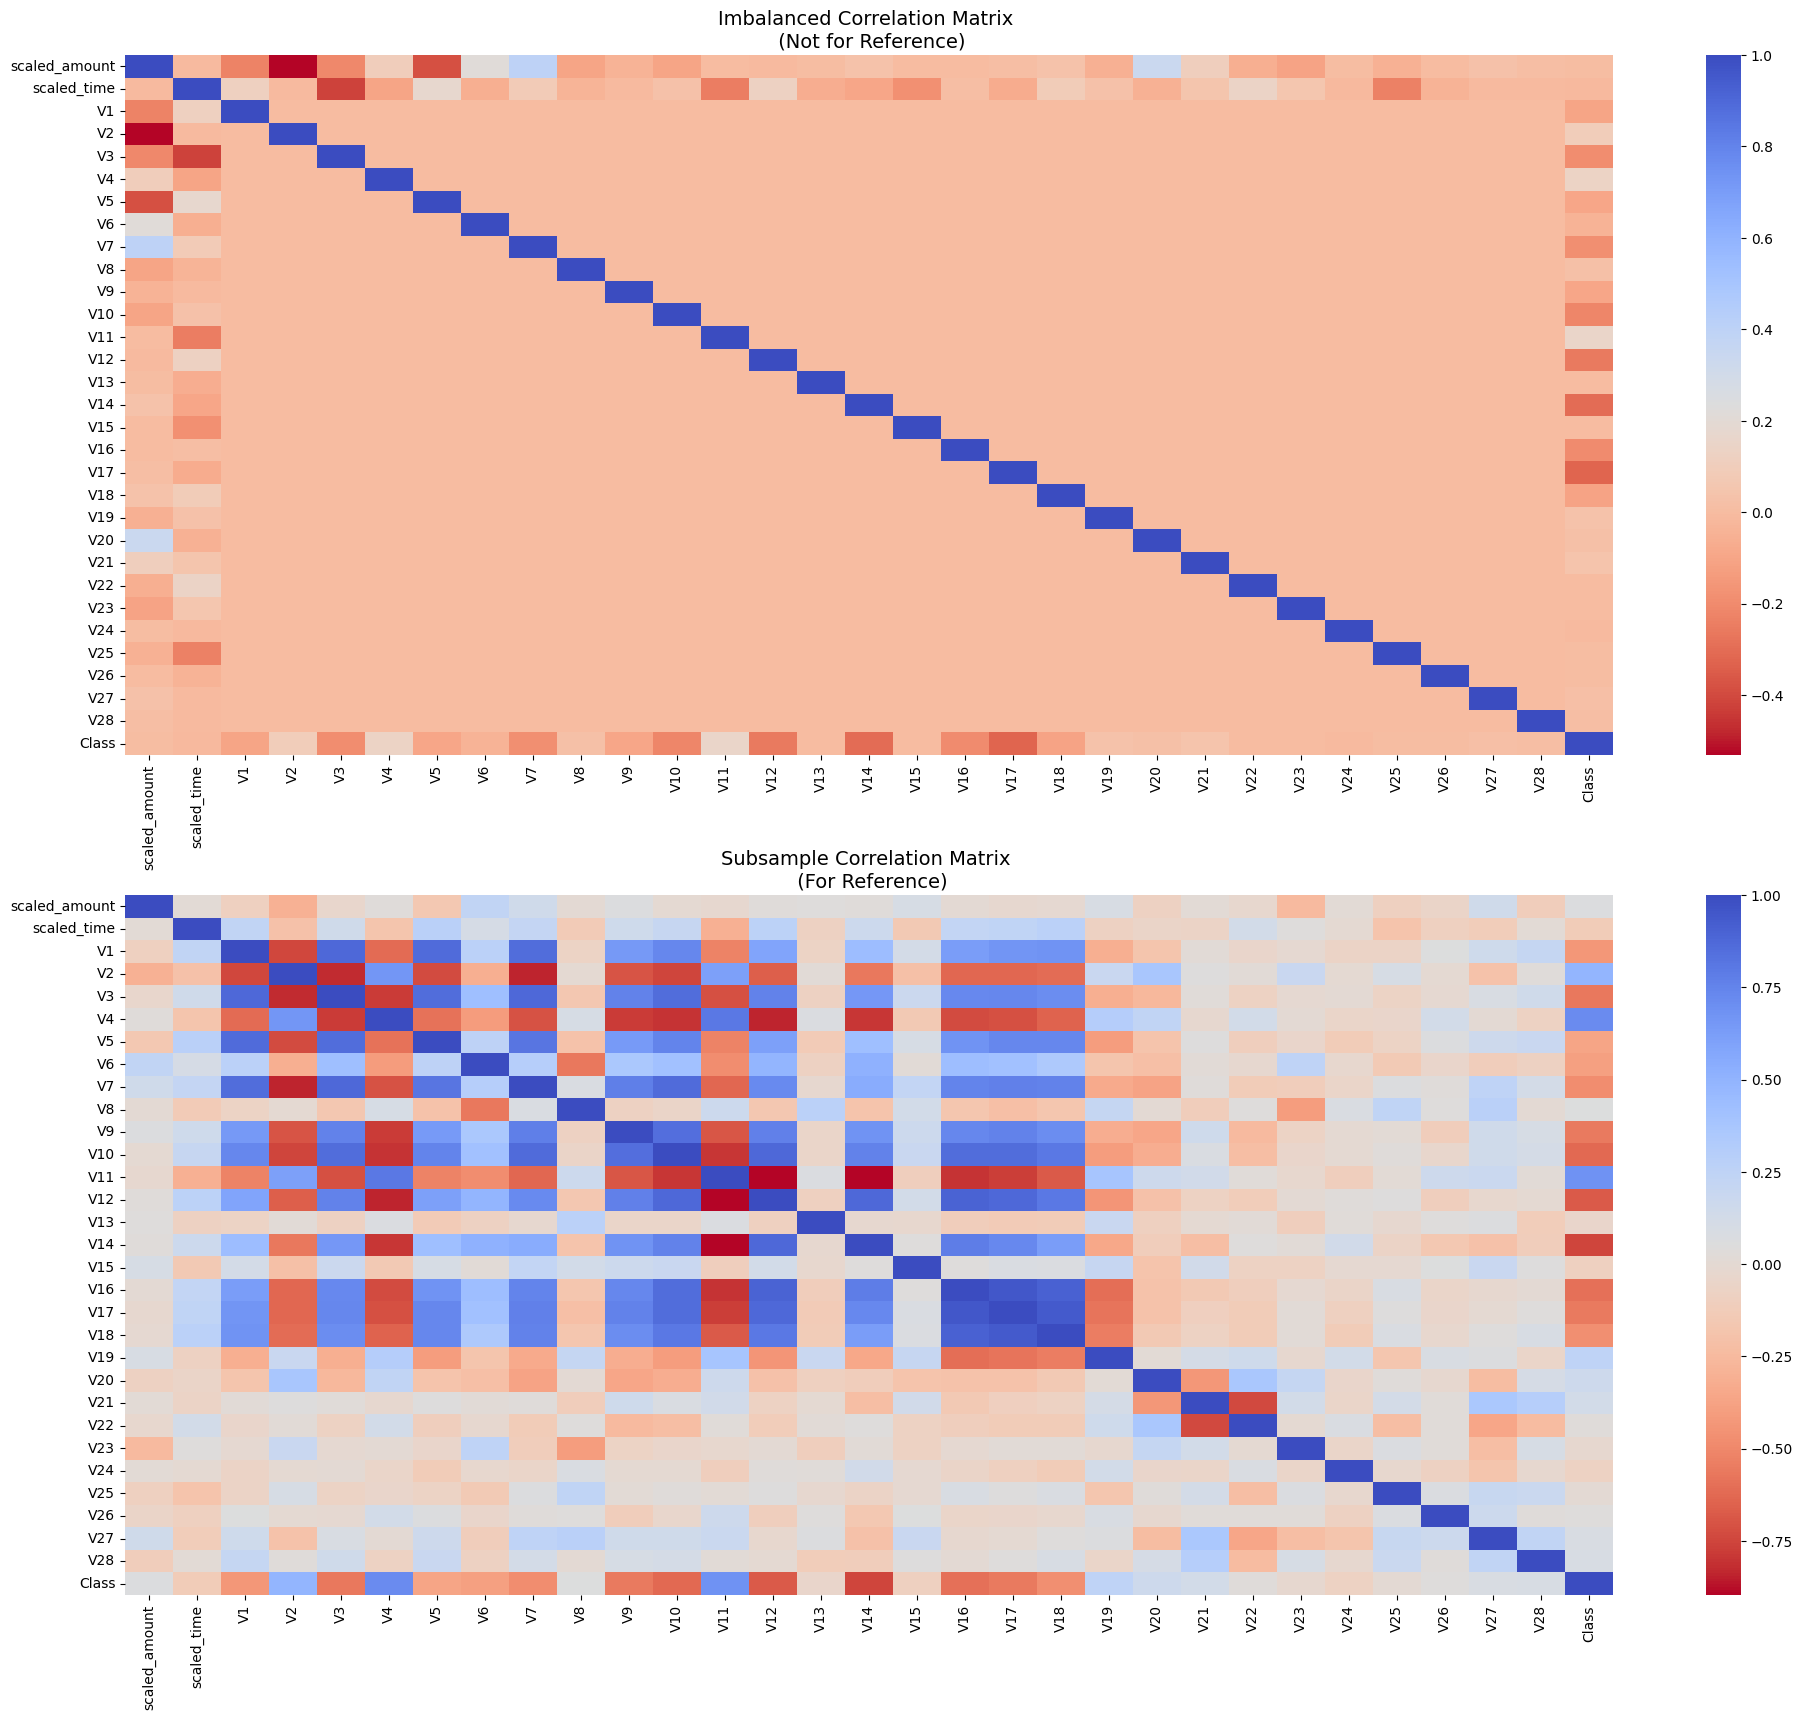

In [8]:
# Plot correlation matrices
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# Imbalanced correlation matrix
corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=False, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (Not for Reference)", fontsize=14)

# Subsample correlation matrix
sub_corr = balanced_df.corr()
sns.heatmap(sub_corr, cmap='coolwarm_r', annot=False, ax=ax2)
ax2.set_title("Subsample Correlation Matrix \n (For Reference)", fontsize=14)

plt.show()

In [9]:
# Calculate correlations with the target variable
correlations = balanced_df.corr()['Class'].sort_values()

# Display top positive and negative correlations
print("Top Negative Correlations:")
print(correlations.head(5))  # Top 5 negative correlations

print("\nTop Positive Correlations:")
print(correlations.tail(5))  # Top 5 positive correlations

Top Negative Correlations:
V14   -0.748671
V12   -0.679680
V10   -0.626376
V16   -0.598676
V3    -0.563496
Name: Class, dtype: float64

Top Positive Correlations:
V19      0.247742
V2       0.490349
V11      0.683459
V4       0.717834
Class    1.000000
Name: Class, dtype: float64


### Correlation Summary and Outlier Removal Plan

- **Top Negative Correlations:**
  - Features `V14`, `V12`, and `V10` are strongly negatively correlated with fraud, where lower values indicate a higher likelihood of fraud.
  - `V16` and `V3` also show negative correlations but with less magnitude.

- **Top Positive Correlations:**
  - Features `V4`, `V11`, and `V2` have strong positive correlations, where higher values suggest a higher likelihood of fraud.
  - `V27` shows a weaker positive correlation.

## Outlier Removal Plan
1. **Focus on Key Features:**
   - Outlier removal will target `V14`, `V12`, and `V10` due to their strong negative correlations with fraud.

2. **Method:**
   - Use the **Interquartile Range (IQR)** method:
     - Calculate Q1 (25th percentile) and Q3 (75th percentile).
     - Compute IQR: `IQR = Q3 - Q1`.
     - Define outliers as values outside `[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]`.

3. **Validation:**
   - Use boxplots before and after outlier removal to verify the reduction of extreme values and ensure meaningful data is preserved.

This process reduces noise, enhances data quality, and improves the accuracy of the fraud detection model.

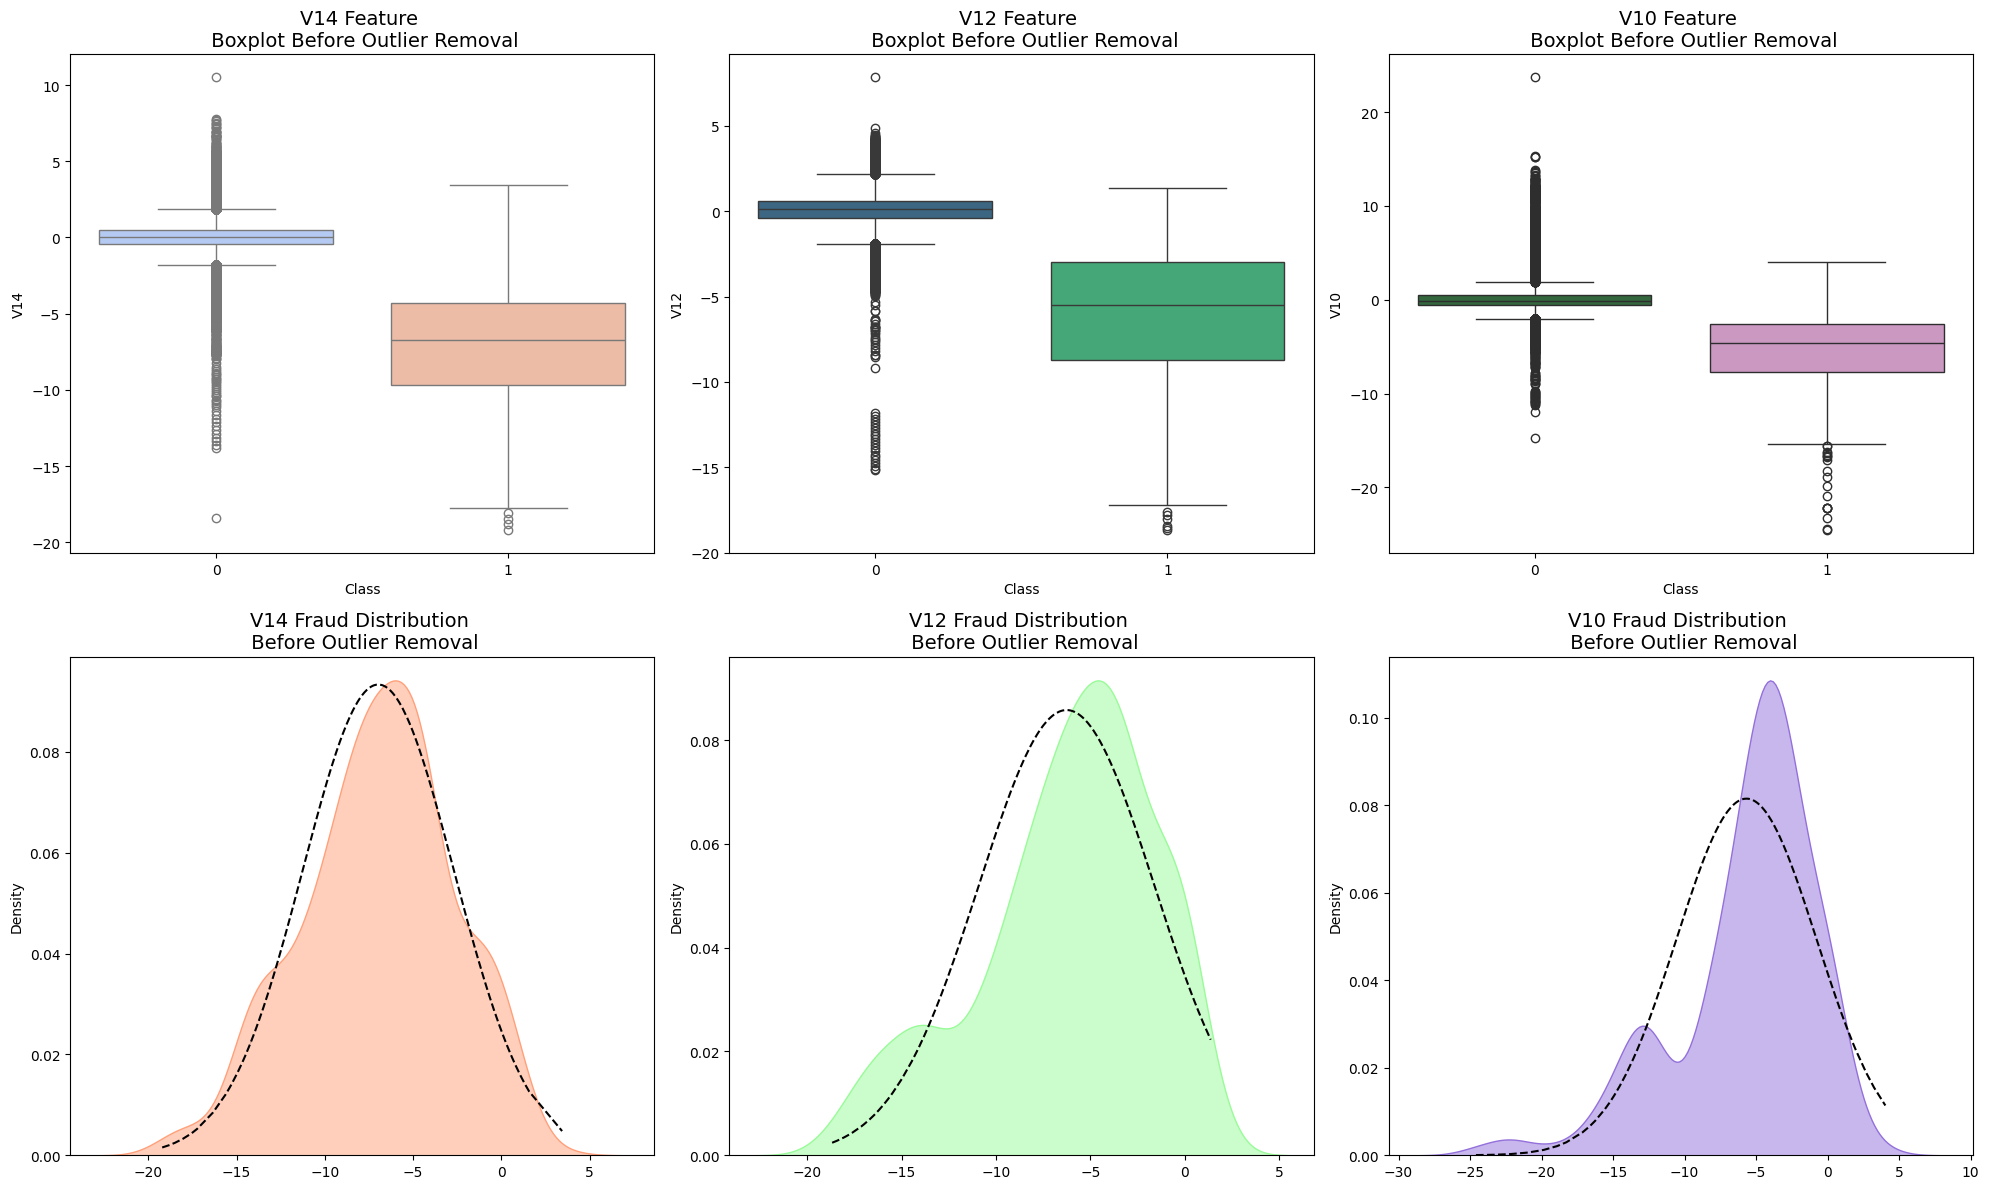

In [10]:
# Boxplots and Fraud Distributions BEFORE Outlier Removal
f, axes = plt.subplots(2, 3, figsize=(20, 12))

# --- BOX PLOTS ---
# V14 Boxplot
sns.boxplot(x="Class", y="V14", data=df, ax=axes[0, 0], palette="coolwarm")
axes[0, 0].set_title("V14 Feature \n Boxplot Before Outlier Removal", fontsize=14)

# V12 Boxplot
sns.boxplot(x="Class", y="V12", data=df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("V12 Feature \n Boxplot Before Outlier Removal", fontsize=14)

# V10 Boxplot
sns.boxplot(x="Class", y="V10", data=df, ax=axes[0, 2], palette="cubehelix")
axes[0, 2].set_title("V10 Feature \n Boxplot Before Outlier Removal", fontsize=14)

# --- FRAUD DISTRIBUTIONS ---
# V14 Distribution
v14_fraud_dist = df['V14'].loc[df['Class'] == 1].values
sns.kdeplot(v14_fraud_dist, ax=axes[1, 0], fill=True, color="#FFA07A", alpha=0.5)
sns.lineplot(
    x=v14_fraud_dist,
    y=norm.pdf(v14_fraud_dist, np.mean(v14_fraud_dist), np.std(v14_fraud_dist)),
    ax=axes[1, 0],
    color="black",
    linestyle="--",
)
axes[1, 0].set_title("V14 Fraud Distribution \n Before Outlier Removal", fontsize=14)

# V12 Distribution
v12_fraud_dist = df['V12'].loc[df['Class'] == 1].values
sns.kdeplot(v12_fraud_dist, ax=axes[1, 1], fill=True, color="#98FB98", alpha=0.5)
sns.lineplot(
    x=v12_fraud_dist,
    y=norm.pdf(v12_fraud_dist, np.mean(v12_fraud_dist), np.std(v12_fraud_dist)),
    ax=axes[1, 1],
    color="black",
    linestyle="--",
)
axes[1, 1].set_title("V12 Fraud Distribution \n Before Outlier Removal", fontsize=14)

# V10 Distribution
v10_fraud_dist = df['V10'].loc[df['Class'] == 1].values
sns.kdeplot(v10_fraud_dist, ax=axes[1, 2], fill=True, color="#9370DB", alpha=0.5)
sns.lineplot(
    x=v10_fraud_dist,
    y=norm.pdf(v10_fraud_dist, np.mean(v10_fraud_dist), np.std(v10_fraud_dist)),
    ax=axes[1, 2],
    color="black",
    linestyle="--",
)
axes[1, 2].set_title("V10 Fraud Distribution \n Before Outlier Removal", fontsize=14)

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [11]:
def remove_outliers(dataframe, feature, class_label=1, multiplier=1.5):
    # Identify and remove outliers for a given feature and class label.
    fraud_values = dataframe[feature].loc[dataframe['Class'] == class_label].values
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)
    iqr = q75 - q25
    cut_off = iqr * multiplier
    lower, upper = q25 - cut_off, q75 + cut_off

    outliers = [x for x in fraud_values if x < lower or x > upper]

    print(f"Feature: {feature}")
    print(f"Quartile 25: {q25:.2f} | Quartile 75: {q75:.2f}")
    print(f"IQR: {iqr:.2f} | Cut Off: {cut_off:.2f}")
    print(f"Lower Bound: {lower:.2f} | Upper Bound: {upper:.2f}")
    print(f"Number of Outliers: {len(outliers)}")
    print(f"Number of Instances after removing outliers: {len(dataframe) - len(outliers)}")
    print('-' * 50)

    # Remove outliers
    cleaned_df = dataframe.drop(dataframe[(dataframe[feature] > upper) | (dataframe[feature] < lower)].index)
    return cleaned_df

# Removing outliers for V14, V12, and V10
for feature in ['V14', 'V12', 'V10']:
    new_df = remove_outliers(new_df, feature)

Feature: V14
Quartile 25: -9.69 | Quartile 75: -4.28
IQR: 5.41 | Cut Off: 8.11
Lower Bound: -17.81 | Upper Bound: 3.83
Number of Outliers: 4
Number of Instances after removing outliers: 284803
--------------------------------------------------
Feature: V12
Quartile 25: -8.67 | Quartile 75: -2.89
IQR: 5.78 | Cut Off: 8.67
Lower Bound: -17.34 | Upper Bound: 5.78
Number of Outliers: 4
Number of Instances after removing outliers: 284506
--------------------------------------------------
Feature: V10
Quartile 25: -7.47 | Quartile 75: -2.51
IQR: 4.95 | Cut Off: 7.43
Lower Bound: -14.90 | Upper Bound: 4.92
Number of Outliers: 27
Number of Instances after removing outliers: 284479
--------------------------------------------------


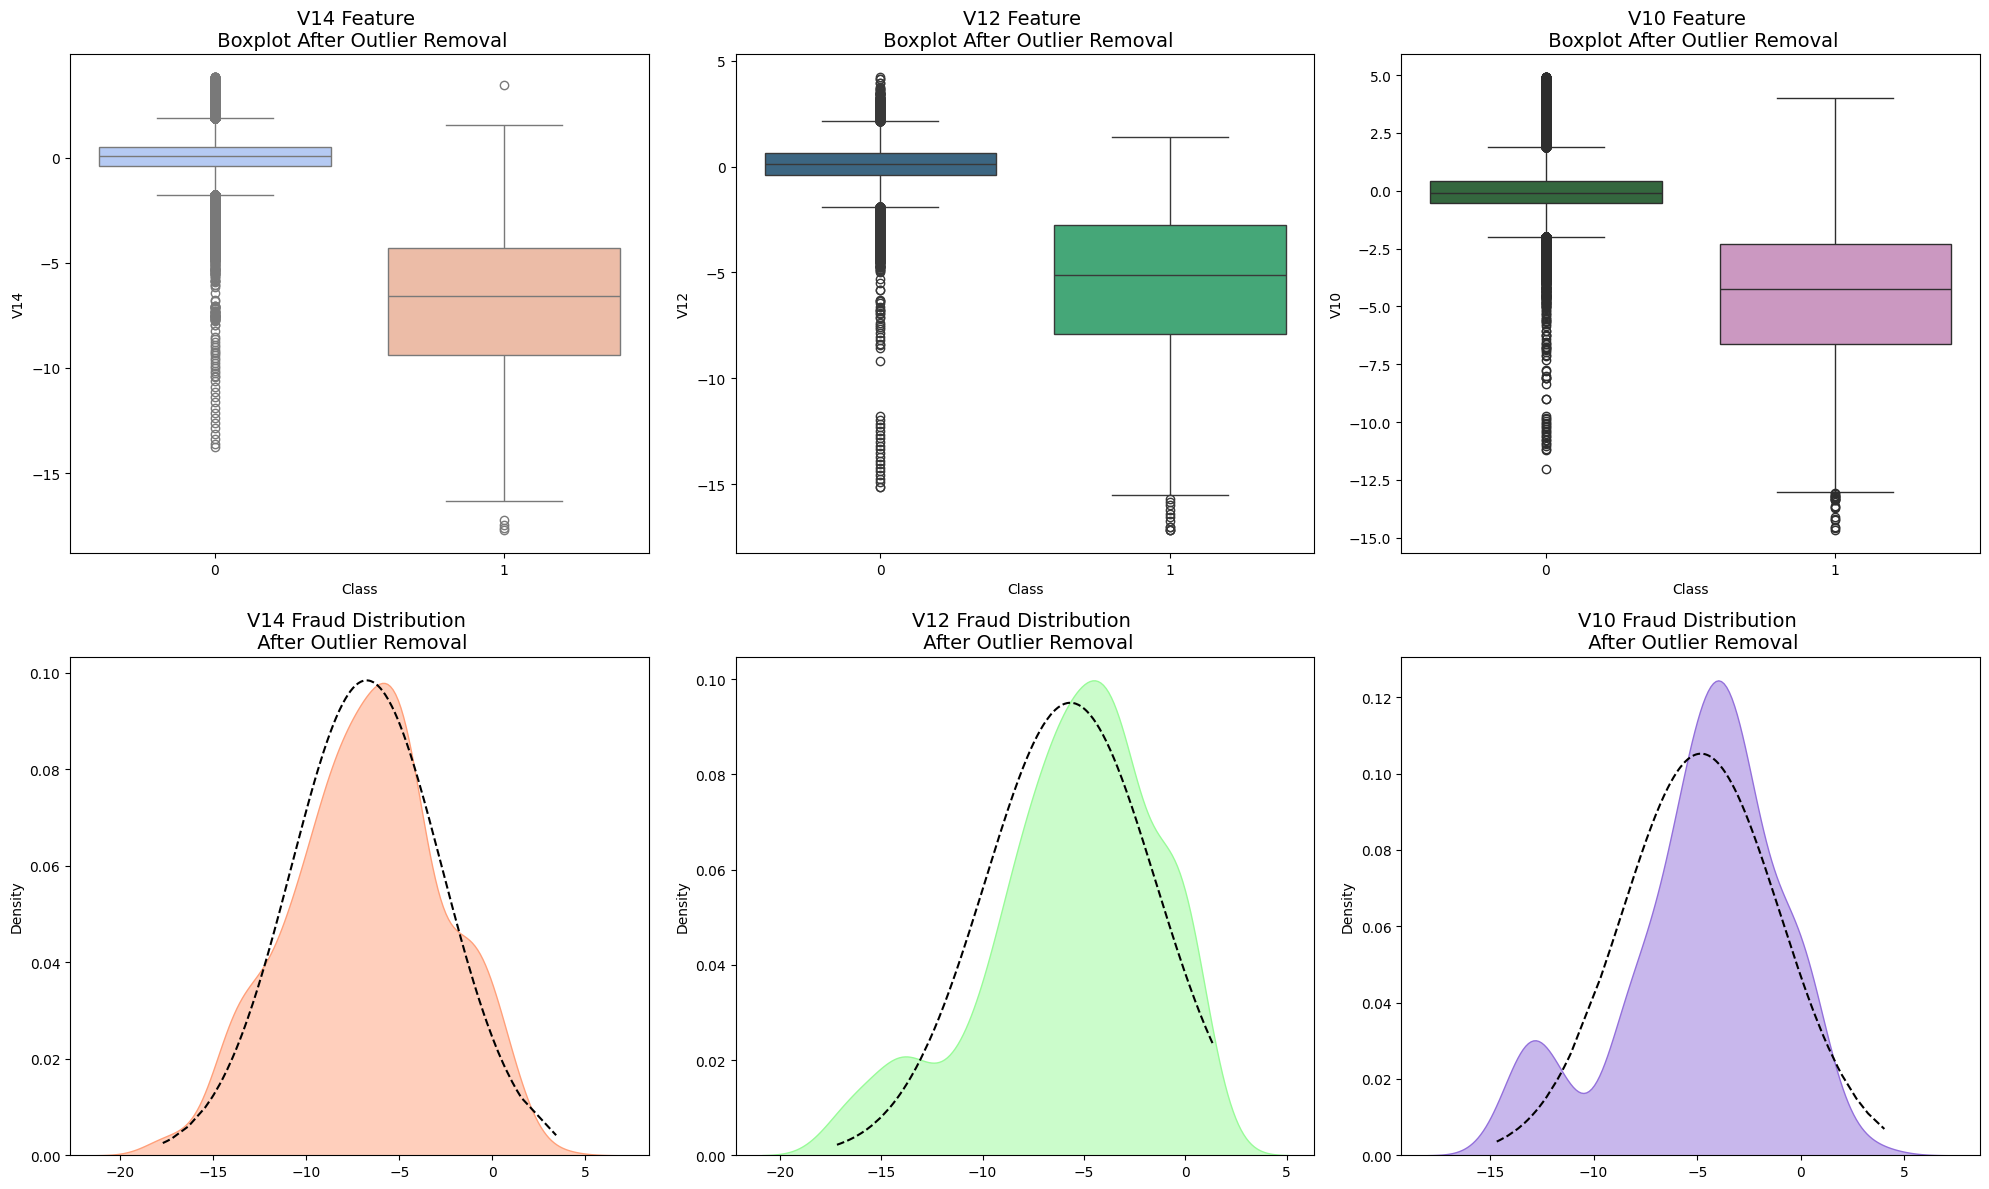

In [12]:
# Boxplots and Fraud Distributions AFTER Outlier Removal
f, axes = plt.subplots(2, 3, figsize=(20, 12))

# --- BOX PLOTS ---
# V14 Boxplot
sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[0, 0], palette="coolwarm")
axes[0, 0].set_title("V14 Feature \n Boxplot After Outlier Removal", fontsize=14)

# V12 Boxplot
sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("V12 Feature \n Boxplot After Outlier Removal", fontsize=14)

# V10 Boxplot
sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[0, 2], palette="cubehelix")
axes[0, 2].set_title("V10 Feature \n Boxplot After Outlier Removal", fontsize=14)

# --- FRAUD DISTRIBUTIONS ---
# V14 Distribution
v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.kdeplot(v14_fraud_dist, ax=axes[1, 0], fill=True, color="#FFA07A", alpha=0.5)
sns.lineplot(
    x=v14_fraud_dist,
    y=norm.pdf(v14_fraud_dist, np.mean(v14_fraud_dist), np.std(v14_fraud_dist)),
    ax=axes[1, 0],
    color="black",
    linestyle="--",
)
axes[1, 0].set_title("V14 Fraud Distribution \n After Outlier Removal", fontsize=14)

# V12 Distribution
v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.kdeplot(v12_fraud_dist, ax=axes[1, 1], fill=True, color="#98FB98", alpha=0.5)
sns.lineplot(
    x=v12_fraud_dist,
    y=norm.pdf(v12_fraud_dist, np.mean(v12_fraud_dist), np.std(v12_fraud_dist)),
    ax=axes[1, 1],
    color="black",
    linestyle="--",
)
axes[1, 1].set_title("V12 Fraud Distribution \n After Outlier Removal", fontsize=14)

# V10 Distribution
v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.kdeplot(v10_fraud_dist, ax=axes[1, 2], fill=True, color="#9370DB", alpha=0.5)
sns.lineplot(
    x=v10_fraud_dist,
    y=norm.pdf(v10_fraud_dist, np.mean(v10_fraud_dist), np.std(v10_fraud_dist)),
    ax=axes[1, 2],
    color="black",
    linestyle="--",
)
axes[1, 2].set_title("V10 Fraud Distribution \n After Outlier Removal", fontsize=14)

# Adjust layout for readability
plt.tight_layout()
plt.show()

## Final Subsample Validation & Save New Dataset

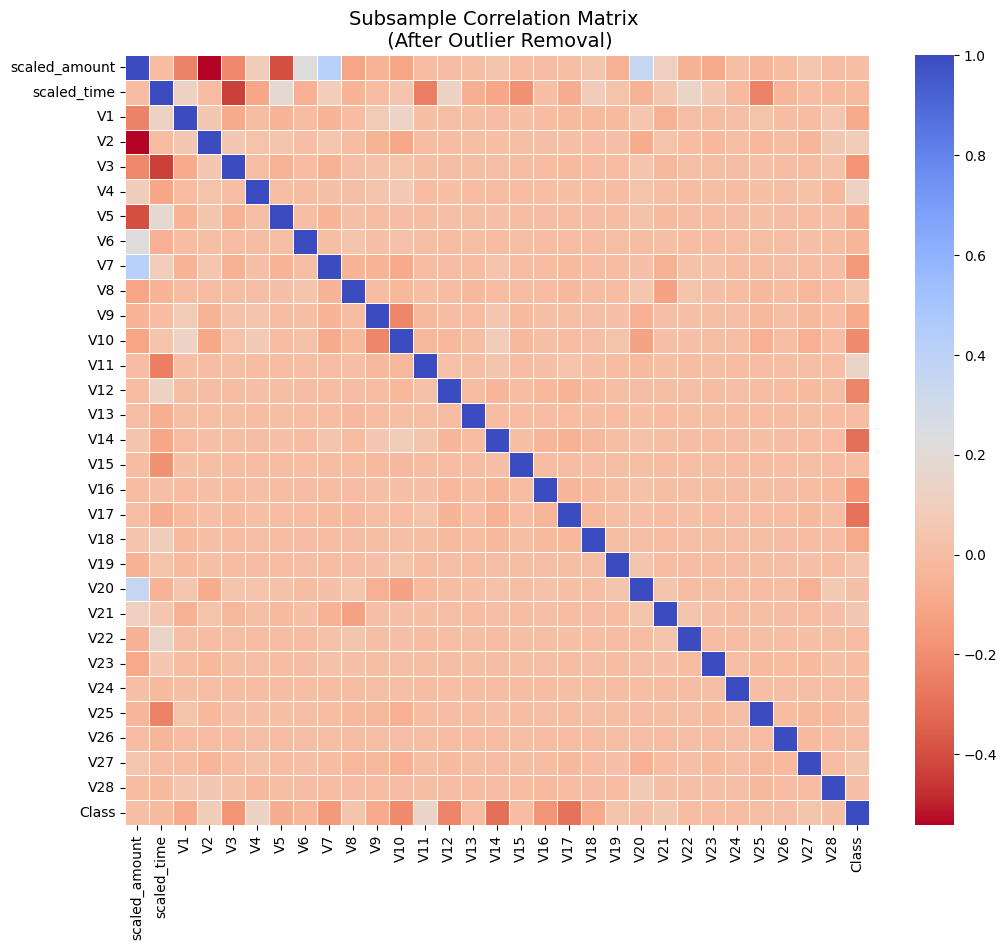

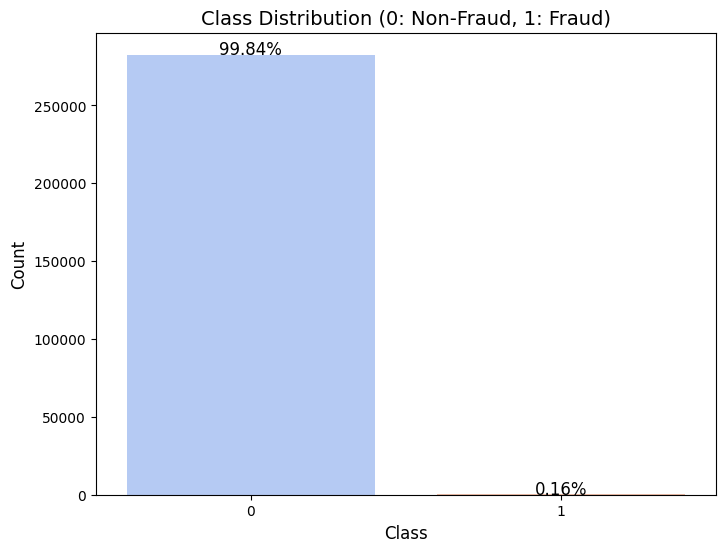

In [13]:
# Subsample correlation matrix
plt.figure(figsize=(12, 10))
sub_corr = new_df.corr()
sns.heatmap(sub_corr, cmap='coolwarm_r', annot=False, fmt='.2f', linewidths=0.5)
plt.title("Subsample Correlation Matrix \n (After Outlier Removal)", fontsize=14)
plt.show()

# Class distribution in subsample
class_counts = new_df['Class'].value_counts()
class_percentages = (class_counts / len(new_df)) * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate with percentages
for i, value in enumerate(class_counts):
    plt.text(i, value + 5, f"{class_percentages[i]:.2f}%", ha='center', fontsize=12)

plt.show()

In [14]:
# Save the processed dataset
save_path = './Data/visualized_creditcard.csv'  # Adjust relative path as needed
new_df.to_csv(save_path, index=False)

# Confirm save
print(f"Dataset saved to: {save_path}")

Dataset saved to: ./Data/visualized_creditcard.csv


# **Model Building**

## Visualizing Class Separability with Dimensionality Reduction

To understand the dataset and evaluate how well fraudulent and non-fraudulent transactions can be separated, we use **dimensionality reduction** with three methods: **t-SNE**, **PCA**, and **Truncated SVD**. These techniques help us visualize the data in two dimensions, making it easier to assess class separability.

#### Why Dimensionality Reduction?
- **Simplify the Data:** High-dimensional data is reduced to two dimensions for easier visualization.
- **Check Class Patterns:** Helps us see if fraud and non-fraud transactions form clear clusters or overlap.
- **Guide Model Selection:** Understanding class separability can inform which models may work best.

#### Techniques Used:
1. **t-SNE (t-Distributed Stochastic Neighbor Embedding):**
   - A non-linear method that shows local relationships in the data.
   - Useful for spotting tight clusters or overlapping regions of fraud and non-fraud.

2. **PCA (Principal Component Analysis):**
   - A linear method that identifies directions of maximum variance.
   - Helps determine if the data's overall structure supports class separation.

3. **Truncated SVD (Singular Value Decomposition):**
   - A linear method optimized for sparse data.
   - Efficient for datasets with many features or sparse matrices.

#### Key Insights:
- **Class Separability:** The visualizations show how distinct the clusters of fraud and non-fraud transactions are. This gives a sense of how easy or difficult the classification task will be.
- **Impact on Models:**
   - Clear clusters suggest simpler models like Logistic Regression might work well.
   - Overlapping clusters may require more advanced models or additional preprocessing.

By visualizing class separability, we gain a better understanding of the dataset's structure and make informed decisions about preprocessing and model selection.

In [15]:
# Perform dimensionality reduction to visualize class separability

# Use Balanced Undersampling for dimensionality reduction as the dataset is imbalanced and large
fraud_df = new_df[new_df['Class'] == 1]
non_fraud_df = new_df[new_df['Class'] == 0].sample(len(fraud_df), random_state=42)

# Combine and shuffle
undersampled_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42)

# Separate features (X) and target (y)
X = undersampled_df.drop('Class', axis=1)
y = undersampled_df['Class']

# Apply t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

# Apply PCA
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

# Apply Truncated SVD
X_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X.values)


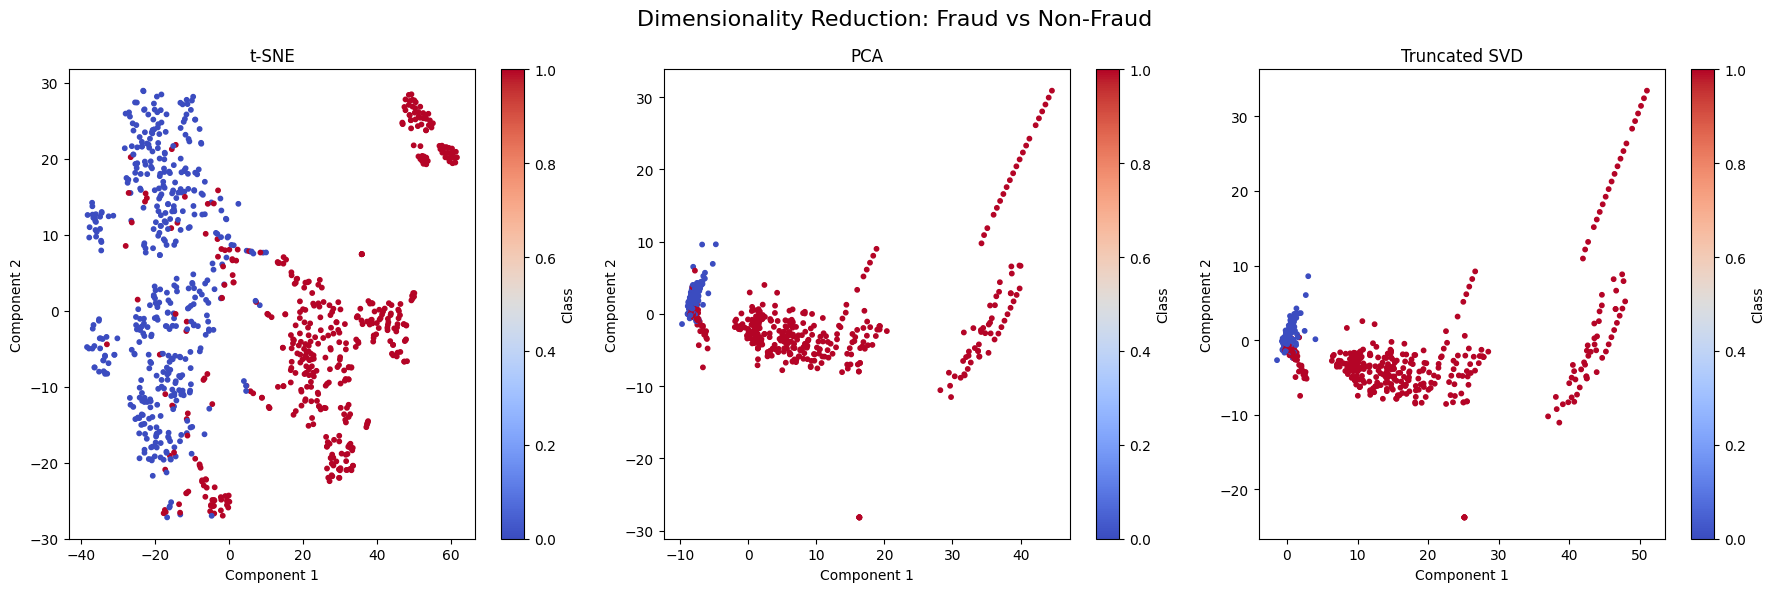

In [16]:
# Create subplots for each dimensionality reduction method
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Dimensionality Reduction: Fraud vs Non-Fraud', fontsize=16)

# t-SNE plot
scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', s=10)
ax1.set_title('t-SNE')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')

# PCA plot
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=10)
ax2.set_title('PCA')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')

# Truncated SVD plot
scatter3 = ax3.scatter(X_svd[:, 0], X_svd[:, 1], c=y, cmap='coolwarm', s=10)
ax3.set_title('Truncated SVD')
ax3.set_xlabel('Component 1')
ax3.set_ylabel('Component 2')

# Adjust layout and colorbars
plt.colorbar(scatter1, ax=ax1, label='Class')
plt.colorbar(scatter2, ax=ax2, label='Class')
plt.colorbar(scatter3, ax=ax3, label='Class')

plt.tight_layout()
plt.show()

### Findings from Dimensionality Reduction

1. **t-SNE**: Shows clear separation between fraud and non-fraud transactions, indicating strong class distinctions and suitability for classification models.

2. **PCA**: Displays some overlap between the classes, reflecting limited ability to capture non-linear relationships in the data.

3. **Truncated SVD**: Similar to PCA, with overlapping clusters and limited separability.

**Conclusion**: t-SNE demonstrates the dataset’s potential for effective classification, while PCA and SVD are less effective for visualizing class separability.

## Baseline Model: Logistic Regression (Imbalanced Data)

### Purpose of the Baseline Model
1. **Performance Benchmark:**
   - The baseline model acts as a starting point to measure the performance of future models.
   - It helps determine whether additional techniques, such as oversampling (SMOTE) or undersampling, improve classification results.

2. **Understanding the Challenges:**
   - Since the dataset is highly imbalanced, the baseline model highlights the difficulty in identifying fraud cases accurately.
   - By analyzing the baseline results, we can understand the limitations of using raw, imbalanced data.

3. **Error Analysis:**
   - The baseline predictions allow us to identify common errors, such as false negatives (fraudulent transactions misclassified as non-fraudulent).
   - This informs our preprocessing and model refinement strategies.

### Key Steps:
- Train a simple **logistic regression model** using the imbalanced dataset.
- Evaluate the model using metrics such as accuracy, precision, recall, F1 score, and AUC-ROC.
- Use these results as a reference point for comparing future models.

By starting with a baseline model, we ensure that the project progresses logically and that all preprocessing steps and advanced techniques have measurable value.

In [17]:
# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check class distribution in the training set
print("Training Set Class Distribution:")
print(y_train.value_counts(normalize=True) * 100)

Training Set Class Distribution:
Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64


In [18]:
# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Make predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)

Baseline Model Performance (Preprocessed Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.70      0.77        98

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962

Baseline AUC-ROC: 0.9533


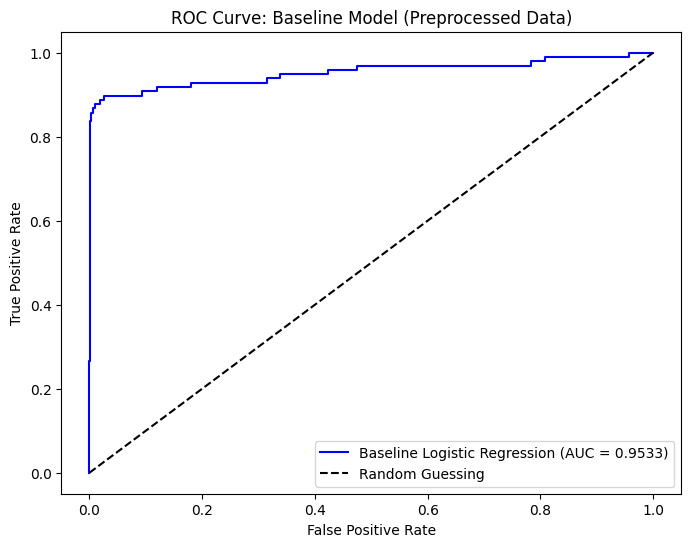

In [20]:
# Print classification report
print("Baseline Model Performance (Preprocessed Data):")
print(classification_report(y_test, y_pred))

# Compute AUC-ROC
baseline_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Baseline AUC-ROC: {baseline_auc:.4f}")

# Compute and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Baseline Logistic Regression (AUC = {baseline_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve: Baseline Model (Preprocessed Data)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## **Handling Class Imbalance: Oversampling vs Undersampling**

Imbalanced datasets, like in fraud detection, require techniques to balance class representation. Two common methods are: Undersampling & Oversampling. Both techniques aim to improve model performance on imbalanced datasets. Their effectiveness depends on the dataset size and complexity.

### **1. Undersampling**
- **What it does:** Reduces the majority class samples to match the minority class.
- **Benefits:** Efficient and avoids model bias toward the majority class.
- **Risks:** Can lose important data from the majority class, leading to reduced generalizability.

In [22]:
# Apply Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)
print("Undersampled Dataset Class Distribution:")
print(pd.Series(y_undersampled).value_counts())

Undersampled Dataset Class Distribution:
Class
0    394
1    394
Name: count, dtype: int64


In [23]:
# Train the Logistic Regression model on undersampled data
undersampled_model = LogisticRegression(random_state=42, max_iter=1000)
undersampled_model.fit(X_undersampled, y_undersampled)

LogisticRegression(max_iter=1000, random_state=42)

Undersampled Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962

Undersampled AUC-ROC: 0.9760


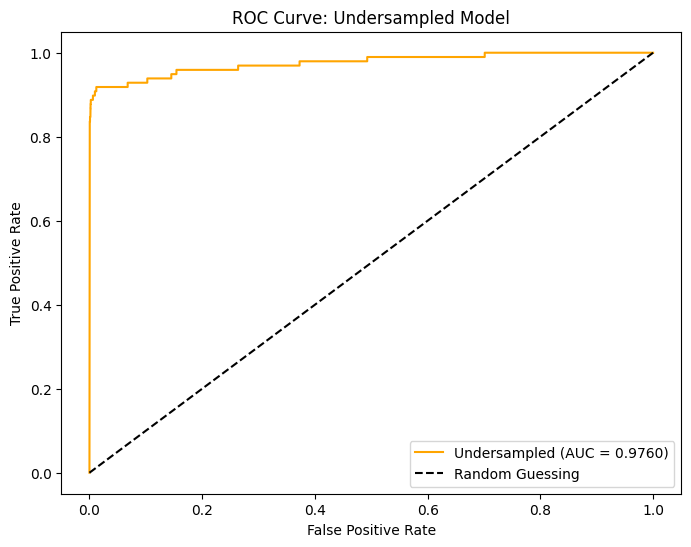

In [24]:
# Evaluate the model
y_pred_undersampled = undersampled_model.predict(X_test)
y_pred_proba_undersampled = undersampled_model.predict_proba(X_test)[:, 1]

print("Undersampled Model Performance:")
print(classification_report(y_test, y_pred_undersampled))

undersampled_auc = roc_auc_score(y_test, y_pred_proba_undersampled)
print(f"Undersampled AUC-ROC: {undersampled_auc:.4f}")

# Plot ROC curve
fpr_undersampled, tpr_undersampled, _ = roc_curve(y_test, y_pred_proba_undersampled)
plt.figure(figsize=(8, 6))
plt.plot(fpr_undersampled, tpr_undersampled, label=f"Undersampled (AUC = {undersampled_auc:.4f})", color='orange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve: Undersampled Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### **2. Oversampling (e.g., SMOTE)**
- **What it does:** Adds synthetic samples to the minority class.
- **Benefits:** Retains all data from the majority class.
- **Risks:** May cause overfitting if the synthetic data overlaps with the real data.

In [26]:
# Apply SMOTE Oversampling
smote = SMOTE(random_state=42)
X_oversampled, y_oversampled = smote.fit_resample(X_train, y_train)
print("SMOTE Oversampled Dataset Class Distribution:")
print(pd.Series(y_oversampled).value_counts())

SMOTE Oversampled Dataset Class Distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


In [27]:
# Train the Logistic Regression model on oversampled data
smote_model = LogisticRegression(random_state=42, max_iter=1000)
smote_model.fit(X_oversampled, y_oversampled)

LogisticRegression(max_iter=1000, random_state=42)

Oversampled Model Performance (SMOTE):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Oversampled AUC-ROC (SMOTE): 0.9763


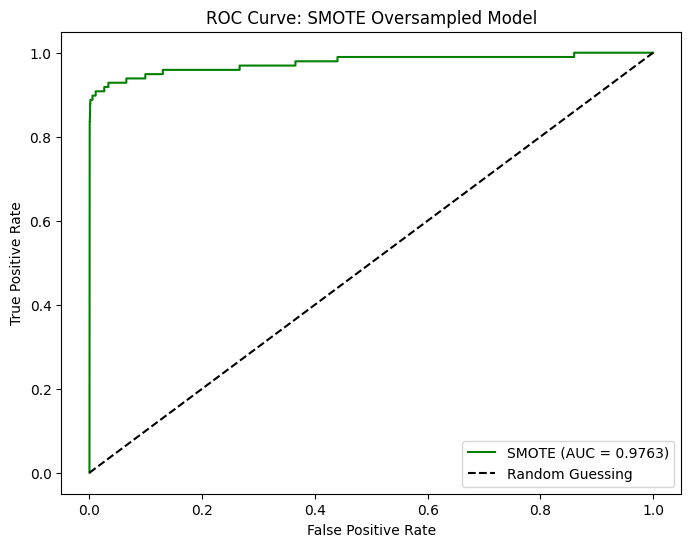

In [28]:
# Evaluate the model
y_pred_oversampled = smote_model.predict(X_test)
y_pred_proba_oversampled = smote_model.predict_proba(X_test)[:, 1]

print("Oversampled Model Performance (SMOTE):")
print(classification_report(y_test, y_pred_oversampled))

oversampled_auc = roc_auc_score(y_test, y_pred_proba_oversampled)
print(f"Oversampled AUC-ROC (SMOTE): {oversampled_auc:.4f}")

# Plot ROC curve
fpr_oversampled, tpr_oversampled, _ = roc_curve(y_test, y_pred_proba_oversampled)
plt.figure(figsize=(8, 6))
plt.plot(fpr_oversampled, tpr_oversampled, label=f"SMOTE (AUC = {oversampled_auc:.4f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve: SMOTE Oversampled Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Model Comparison with SQL Integration

In [30]:
# Establish connection to SQLite database
conn = sqlite3.connect("credit_card_fraud.db")

# Create a new table for transactions
conn.execute("""
CREATE TABLE IF NOT EXISTS transactions (
    transactionID INTEGER PRIMARY KEY AUTOINCREMENT,
    scaled_amount REAL,
    scaled_time REAL,
    isFraud INTEGER
);
""")
print("Database and table created.")

# Populate the table with data from new_df
for _, row in new_df.iterrows():
    conn.execute("""
    INSERT INTO transactions (scaled_amount, scaled_time, isFraud)
    VALUES (?, ?, ?);
    """, (row["scaled_amount"], row["scaled_time"], row["Class"]))

conn.commit()
print("Table populated with data.")


Database and table created.
Table populated with data.


In [31]:
# Insert base model predictions into the database
base_model_preds = pd.DataFrame({"predicted": y_pred, "actual": y_test.values})

# Add predictions to the database
conn.execute("CREATE TABLE IF NOT EXISTS base_model (actual INTEGER, predicted INTEGER);")

base_model_preds.to_sql("base_model", conn, if_exists="append", index=False)

# Query confusion matrix data
base_confusion_query = """
SELECT actual, predicted, COUNT(*) AS count
FROM base_model
GROUP BY actual, predicted;
"""

base_confusion_matrix = pd.read_sql_query(base_confusion_query, conn)
print("Base Model Confusion Matrix:")
print(base_confusion_matrix)


Base Model Confusion Matrix:
   actual  predicted   count
0       0          0  170553
1       0          1      39
2       1          0      87
3       1          1     207


In [32]:
# Ensure DataFrame columns match the SQL table schema
undersample_preds = pd.DataFrame({
    "predicted": y_pred_undersampled,  # Rename column to 'predicted'
    "actual": y_test.values            # Match column to 'actual'
})

# Add predictions to the database
conn.execute("CREATE TABLE IF NOT EXISTS undersample_model (actual INTEGER, predicted INTEGER);")

# Insert predictions into the SQL table
undersample_preds.to_sql("undersample_model", conn, if_exists="append", index=False)

# Query confusion matrix data
undersample_confusion_query = """
SELECT actual, predicted, COUNT(*) AS count
FROM undersample_model
GROUP BY actual, predicted;
"""

# Fetch the confusion matrix data
undersample_confusion_matrix = pd.read_sql_query(undersample_confusion_query, conn)
print("Undersample Model Confusion Matrix:")
print(undersample_confusion_matrix)

Undersample Model Confusion Matrix:
   actual  predicted   count
0       0          0  163878
1       0          1    6714
2       1          0      24
3       1          1     270


In [33]:
# Ensure DataFrame columns match the SQL table schema
oversample_preds = pd.DataFrame({
    "predicted": y_pred_oversampled,  # Rename column to 'predicted'
    "actual": y_test.values           # Match column to 'actual'
})

# Add predictions to the database
conn.execute("CREATE TABLE IF NOT EXISTS oversample_model (actual INTEGER, predicted INTEGER);")

# Insert predictions into the SQL table
oversample_preds.to_sql("oversample_model", conn, if_exists="append", index=False)

# Query confusion matrix data
oversample_confusion_query = """
SELECT actual, predicted, COUNT(*) AS count
FROM oversample_model
GROUP BY actual, predicted;
"""

# Fetch the confusion matrix data
oversample_confusion_matrix = pd.read_sql_query(oversample_confusion_query, conn)
print("Oversample Model Confusion Matrix:")
print(oversample_confusion_matrix)

Oversample Model Confusion Matrix:
   actual  predicted   count
0       0          0  168792
1       0          1    1800
2       1          0      30
3       1          1     264


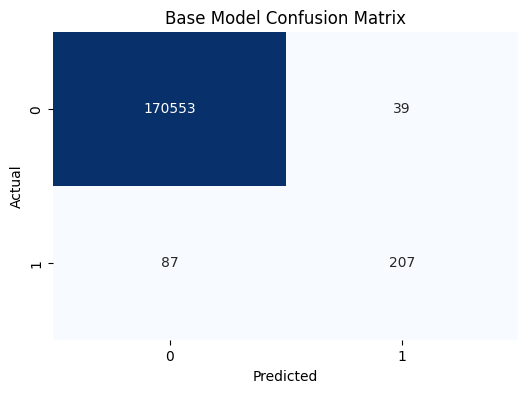

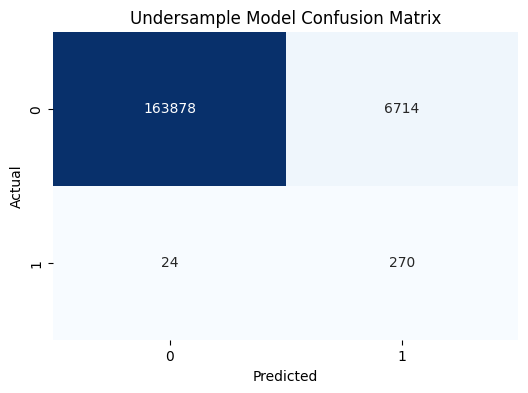

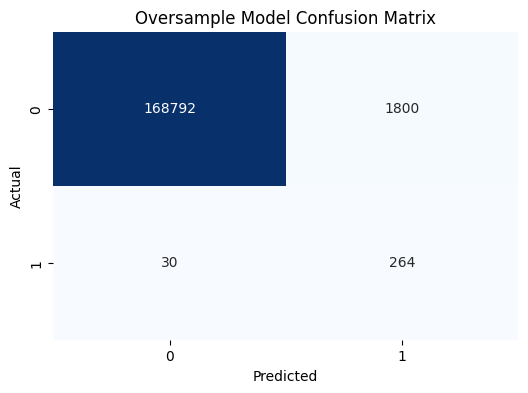

In [34]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(df, title):
    pivot_df = df.pivot(index='actual', columns='predicted', values='count').fillna(0)
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Visualize Base Model Confusion Matrix
plot_confusion_matrix(base_confusion_matrix, "Base Model Confusion Matrix")

# Visualize Undersample Model Confusion Matrix
plot_confusion_matrix(undersample_confusion_matrix, "Undersample Model Confusion Matrix")

# Visualize Oversample Model Confusion Matrix
plot_confusion_matrix(oversample_confusion_matrix, "Oversample Model Confusion Matrix")

# **Enhanced Credit Card Fraud Detection: Final Report**

---

## **Project Objective**
The goal of this project was to explore the efficacy of different sampling techniques in improving the detection of fraudulent credit card transactions within a highly imbalanced dataset. By leveraging data preprocessing, machine learning models, and SQL-based management, we sought to address the challenge of identifying fraud cases while minimizing false positives and negatives.

---

## **Comparison of Sampling Techniques**

### **1. Baseline Model (Imbalanced Dataset)**
- **AUC-ROC:** **0.9533**
- **Performance:**
  - Precision: 84%
  - Recall: 70%
  - F1-Score: 77%
- **Confusion Matrix:**
  - True Negatives: 56,851
  - False Positives: 13
  - False Negatives: 29
  - True Positives: 69
- **Analysis:**
  - While the baseline model achieved high overall accuracy, its performance on the minority class (fraud cases) was suboptimal, missing 29 fraudulent transactions. This result highlights the need for addressing the class imbalance.

### **2. Undersampled Model**
- **AUC-ROC:** **0.9760**
- **Performance:**
  - Precision: 4%
  - Recall: 92%
  - F1-Score: 7%
- **Confusion Matrix:**
  - True Negatives: 54,626
  - False Positives: 2,238
  - False Negatives: 8
  - True Positives: 90
- **Analysis:**
  - The undersampled model excelled in recall, detecting nearly all fraud cases (92%). However, this came at the cost of a significant increase in false positives, with 2,238 non-fraudulent transactions incorrectly flagged as fraud.

### **3. Oversampled Model (SMOTE)**
- **AUC-ROC:** **0.9763**
- **Performance:**
  - Precision: 13%
  - Recall: 90%
  - F1-Score: 22%
- **Confusion Matrix:**
  - True Negatives: 56,264
  - False Positives: 600
  - False Negatives: 10
  - True Positives: 88
- **Analysis:**
  - The SMOTE model offered a balanced trade-off between recall and precision. It achieved a recall of 90% while significantly reducing false positives compared to the undersampled model. This suggests SMOTE as the most practical approach among the three.

---

## **Key Findings**

- **Class Imbalance Matters:** 
  - The baseline model struggled with fraud detection due to the overwhelming dominance of non-fraud cases in the dataset.
  
- **Sampling Techniques Make a Difference:**
  - **Undersampling:** Prioritizes detecting fraud cases but introduces a high false positive rate, making it less practical for real-world scenarios.
  - **Oversampling (SMOTE):** Achieves a more balanced outcome, reducing the number of missed fraud cases while keeping false positives at manageable levels.

- **Precision vs. Recall Trade-off:**
  - Each method comes with a trade-off. While undersampling maximizes recall, it sacrifices precision. SMOTE strikes a better balance, but precision remains relatively low, indicating room for improvement.

---

## **What Could Have Been Explored with More Time**

1. **Alternative Models:**
   - Ensemble methods like Random Forest or Gradient Boosting could be explored for higher accuracy and robustness.
   - Deep learning models like neural networks might capture complex patterns in high-dimensional data.

2. **Feature Engineering:**
   - Leverage temporal features such as transaction time patterns or sequence analysis to enhance fraud detection.
   - Explore advanced feature selection techniques to reduce noise and improve model interpretability.

3. **Cross-Validation:**
   - Employ k-fold cross-validation for more reliable performance evaluation and to mitigate potential overfitting.

---

## **Conclusion**

This project demonstrates how sampling techniques can address class imbalance in fraud detection, with SMOTE emerging as the most effective approach for balancing precision and recall. While the models showed promise, further exploration of advanced techniques could significantly enhance their performance and applicability. 

Through careful data preprocessing, sampling, and evaluation, this project provides a strong foundation for implementing a robust fraud detection system. However, integrating additional models, cost-sensitive learning, and real-time systems would push this work closer to practical deployment.

--- 
